# Vehicle loan default Prediction. 
---
Financial institutions face losses when borrowers default on their vehicle loans. To address this issue, we are analyzing a dataset sourced from Kaggle to predict the likelihood of a borrower defaulting on their vehicle loan during the first installment payment (EMI). Our objective is to develop a model that can accurately predict whether a borrower will successfully make their first EMI payment before disbursing their loan. To accomplish this, we are focusing on features that are available at the time of the loan application. By considering these features, we aim to create a useful tool for financial institutions to assess the creditworthiness of potential borrowers and mitigate the risk of loan defaults.



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import scipy.stats as stats
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn import model_selection
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from scipy.stats import zscore
from scipy.stats import ttest_ind
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
df =pd.read_csv('train.csv')



In [2]:
column_list = df.columns.values.tolist()
print(column_list)
missing_percentages = df.isna().mean() * 100
print(missing_percentages)

['UNIQUEID', 'DISBURSED_AMOUNT', 'ASSET_COST', 'LTV', 'BRANCH_ID', 'SUPPLIER_ID', 'MANUFACTURER_ID', 'CURRENT_PINCODE_ID', 'DATE_OF_BIRTH', 'EMPLOYMENT_TYPE', 'DISBURSAL_DATE', 'STATE_ID', 'EMPLOYEE_CODE_ID', 'MOBILENO_AVL_FLAG', 'AADHAR_FLAG', 'PAN_FLAG', 'VOTERID_FLAG', 'DRIVING_FLAG', 'PASSPORT_FLAG', 'PERFORM_CNS_SCORE', 'PERFORM_CNS_SCORE_DESCRIPTION', 'PRI_NO_OF_ACCTS', 'PRI_ACTIVE_ACCTS', 'PRI_OVERDUE_ACCTS', 'PRI_CURRENT_BALANCE', 'PRI_SANCTIONED_AMOUNT', 'PRI_DISBURSED_AMOUNT', 'SEC_NO_OF_ACCTS', 'SEC_ACTIVE_ACCTS', 'SEC_OVERDUE_ACCTS', 'SEC_CURRENT_BALANCE', 'SEC_SANCTIONED_AMOUNT', 'SEC_DISBURSED_AMOUNT', 'PRIMARY_INSTAL_AMT', 'SEC_INSTAL_AMT', 'NEW_ACCTS_IN_LAST_SIX_MONTHS', 'DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS', 'AVERAGE_ACCT_AGE', 'CREDIT_HISTORY_LENGTH', 'NO_OF_INQUIRIES', 'LOAN_DEFAULT']
UNIQUEID                               0.000000
DISBURSED_AMOUNT                       0.000000
ASSET_COST                             0.000000
LTV                                    0.

### Removing missing values
---

In [3]:
num_rows = len(df)
print(num_rows)
df=df.dropna()
num_rows=len(df)
print(num_rows)

233154
225493


# Feature Selection
---
In this phase of the analysis the features are  being evaluated using the domain knowledge to assess whether it is worthy to include them in the model.
## Domain Knowledge Analysis
---
### List Of Features
---
1. UNIQUEID = This is the primary key of the database thus this has been removed 
---
2. Disbursed Amount = <br>The disbursed amount of a loan refers to the actual amount of money that a borrower receives from a lender after the loan application has been approved and processed. This amount may be different from the loan amount initially requested by the borrower, as it factors in any fees, charges or deductions that may apply to the loan. The disbursed amount is subject to the terms and conditions of the loan, such as repayment schedules, interest rates, and other applicable fees.
---
3. branch id = The 'branch ID' is not relevant to the borrower's ability to repay the loan. This feature does not provide any meaningful information or insights that would contribute to predicting loan repayment. Since our goal is to build an accurate model that focuses on borrower-related factors, including 'branch ID' as a feature would introduce noise and potentially hinder the model's performance. Therefore, to enhance the model's effectiveness and remove unnecessary complexity, the 'branch ID' feature has been excluded from the analysis.
---
4. supplier id = Belongs to the same calss as branch id thus has been removed
---
5. manufacturer id = Belongs to the same calss as branch id thus has been removed
---
6. current pincode = Eventhough this a borrower elated information this is very specific to the borrower which will lead to the overfitting of the model. belongs to the categery of unique features.
---
7. disbursal date = Ths feature of the dataset is decided by the bank thus it is not a feature of the borrower.
---
8. state id = Eventhough this is a feature of the borrower ethical considerations and potential biases that may arise from including  geographical locationas a feature in a model can raise concerns about discrimination and unfair bias, as it may lead to certain regions or demographics being unfairly labeled as high-risk borrowers. 
---
9. employee code = "Employee of the organization who logged the disbursement" Cleary this is not a feature of the borrower so this has been excluded from the mdoel.
---
10. PERFORM_CNS_SCORE_DESCRIPTION = Simce we have included the PERFORM_CNS_SCORE to the model as a value the perform cns core description feature has been avoided. 

In [4]:
df=df.drop(['UNIQUEID','DISBURSED_AMOUNT','BRANCH_ID','SUPPLIER_ID','MANUFACTURER_ID',
            'CURRENT_PINCODE_ID','DISBURSAL_DATE','STATE_ID','EMPLOYEE_CODE_ID',
            'PERFORM_CNS_SCORE_DESCRIPTION'],axis=1)

## Data Preprocessing
---
In this Step all the features are being processed.

### Dealing with quantitative data
---
Handling sensitive personal data, such as "date of birth," properly is crucial to uphold privacy concerns and adhere to data protection laws. The 'date of birth' function has been changed to 'age' as a privacy-conscious method by figuring out the borrower's age at the time of analysis. This translation frees us from the necessity of directly storing or processing sensitive birth dates while preserving the significant element of the borrower's age as a possible predictor of loan payback.

We may take advantage of the probable connection between a borrower's age and their capacity to repay a loan by putting 'age' as a characteristic. Age is frequently linked to elements like financial security, employment history, and creditworthiness, all of which may have an impact on how loans are repaid. 

In [5]:
df['DATE_OF_BIRTH'] = pd.to_datetime(df['DATE_OF_BIRTH'])
today = datetime.datetime.now()
df['AGE'] = df['DATE_OF_BIRTH'].apply(lambda x: today.year - x.year - ((today.month, today.day) < (x.month, x.day)))
# drop date of birth column
df.drop('DATE_OF_BIRTH', axis=1, inplace=True)
# move age column before employment_type column
cols = df.columns.tolist()
cols.remove('AGE')
cols.insert(cols.index('EMPLOYMENT_TYPE'), 'AGE')
df = df[cols]
#print(df.head())

<ipython-input-5-7121945faa51>:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['DATE_OF_BIRTH'] = pd.to_datetime(df['DATE_OF_BIRTH'])


The time elements in the dataset have been translated into a single format of "months" to maintain consistency and make analysis easier. The analysis, comparison, and calculation of time-related patterns and trends within the dataset are made easier by this conversion.

We remove any potential inconsistencies that can result from measuring time in different units (e.g., years and months) by converting all time features to the'months' format. The model is better able to detect and interpret time-related fluctuations in the dataset as a result of this standardisation.

Additionally, using months as a unit of measurement is consistent with the level of detail needed for the task of predicting loan payback. The monthly timeframe is frequently ideal for recording pertinent trends in borrower behaviour, repayment patterns, and other time-dependent variables that might affect loan payback.

In [6]:
def convert_to_months(s):
    y, m = s.split()
    y = int(y[:-3])
    m = int(m[:-3])
    return y * 12 + m
df['average_acct_age_month'] = df['AVERAGE_ACCT_AGE'].apply(convert_to_months)
df['credit_history_month'] = df['CREDIT_HISTORY_LENGTH'].apply(convert_to_months)
df.drop(['AVERAGE_ACCT_AGE', 'CREDIT_HISTORY_LENGTH'], axis=1, inplace=True)


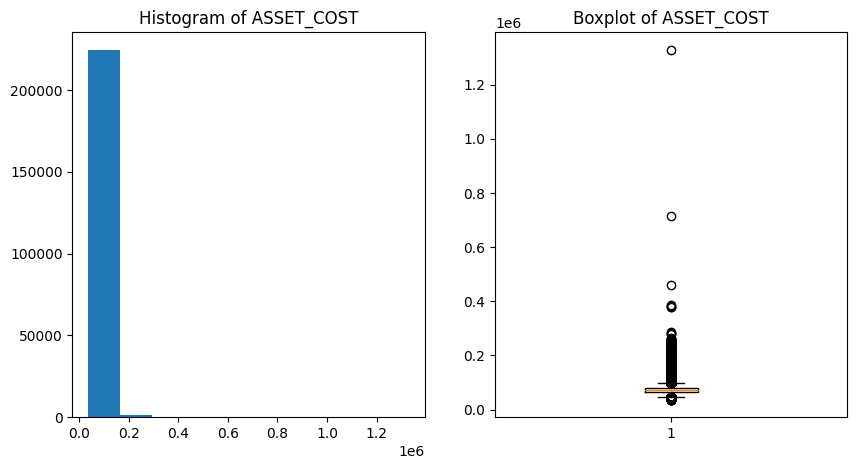

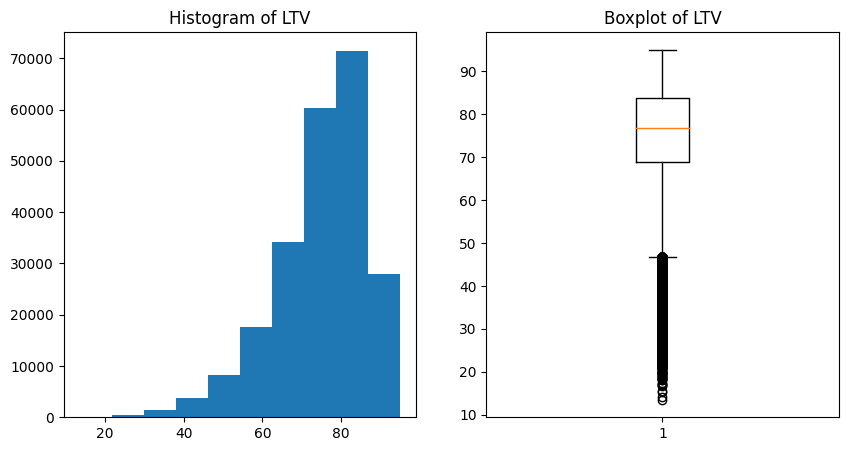

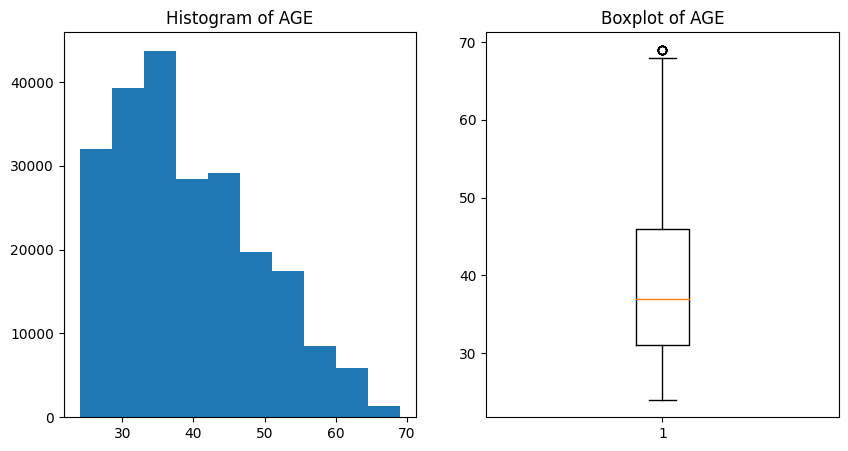

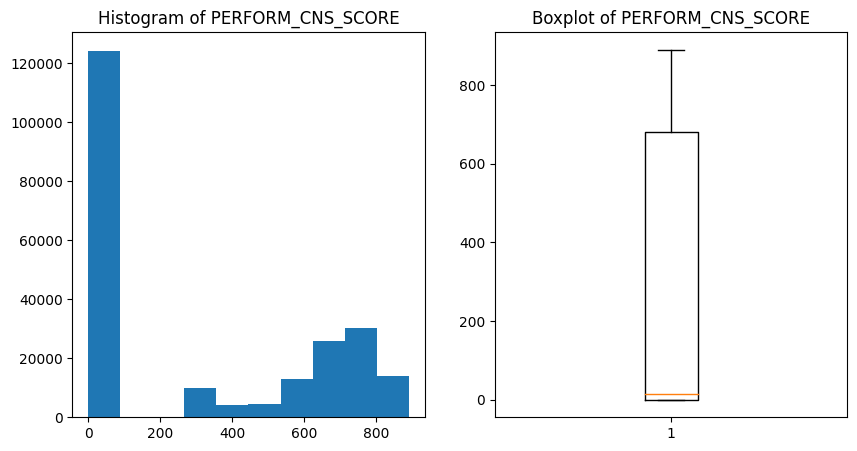

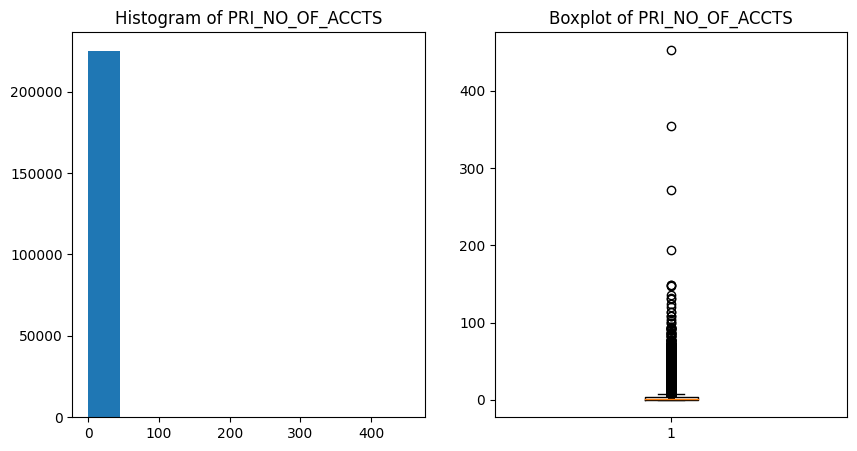

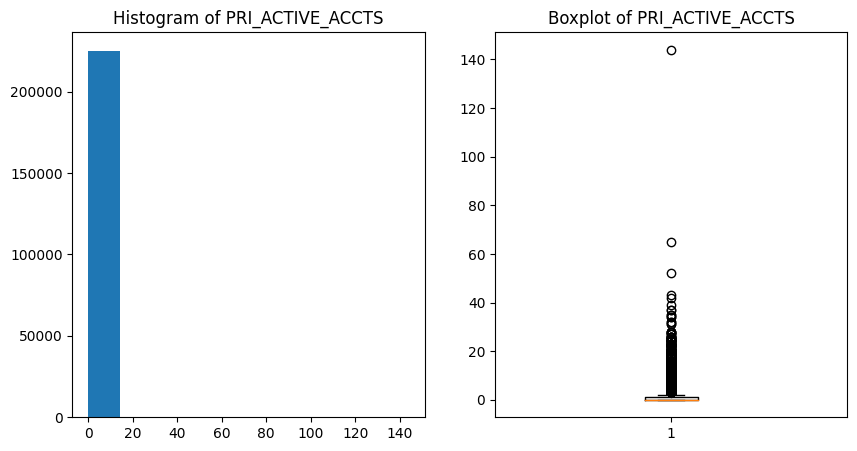

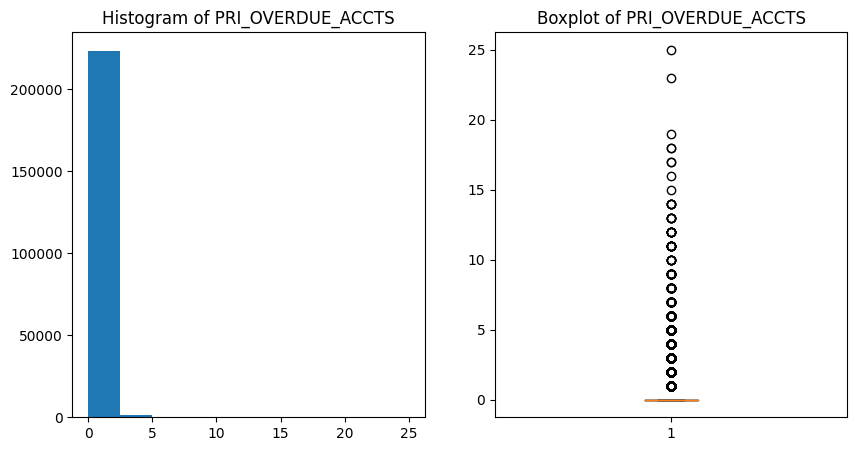

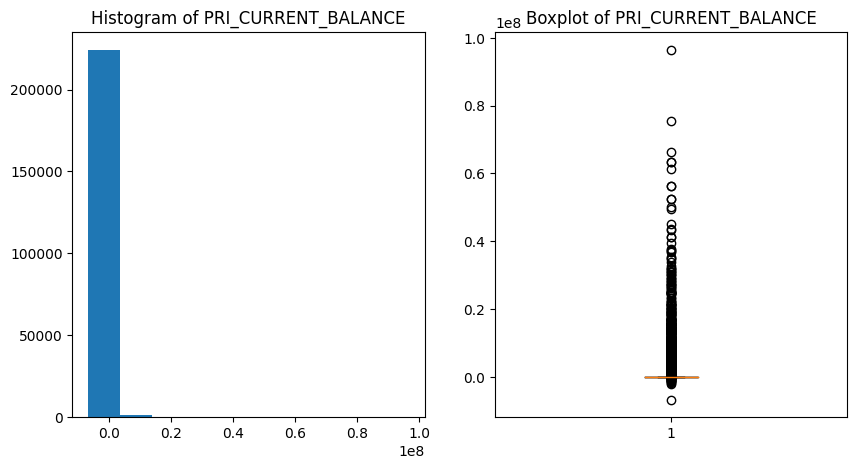

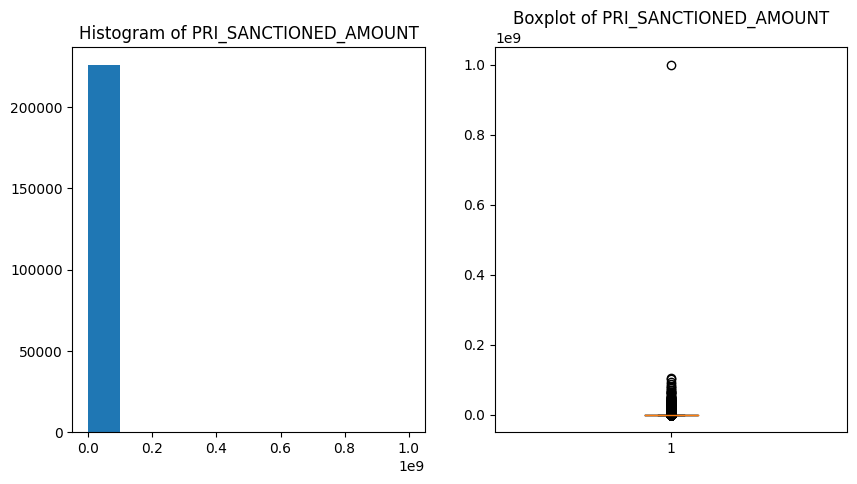

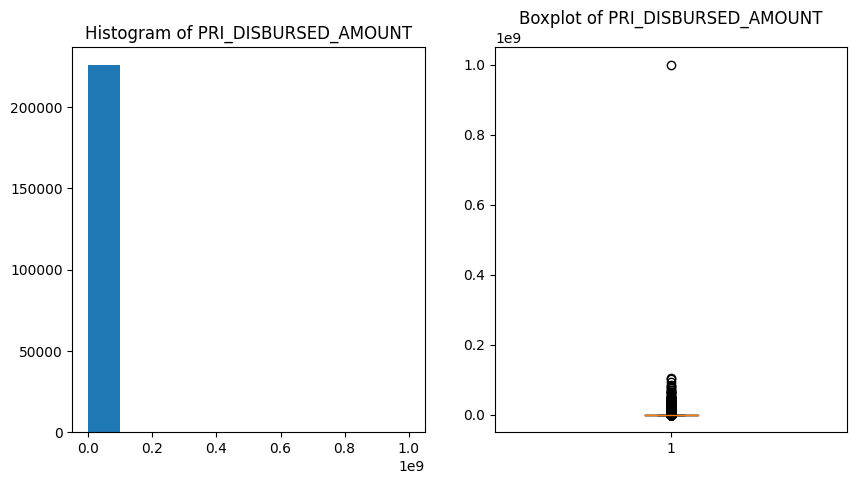

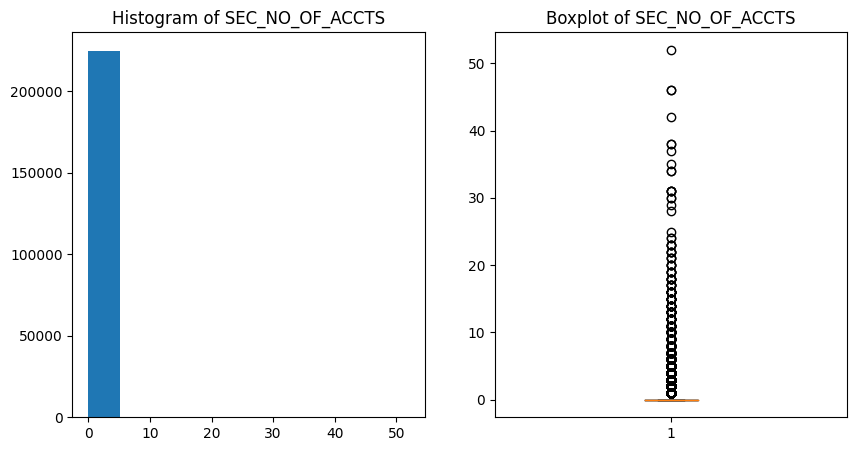

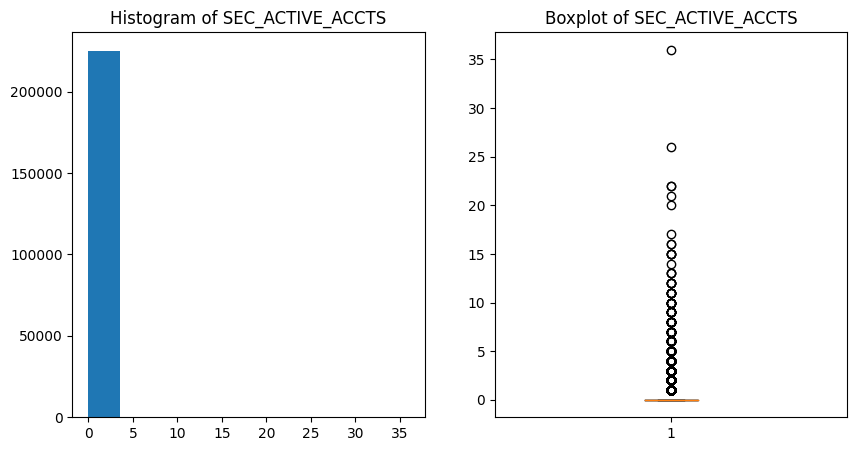

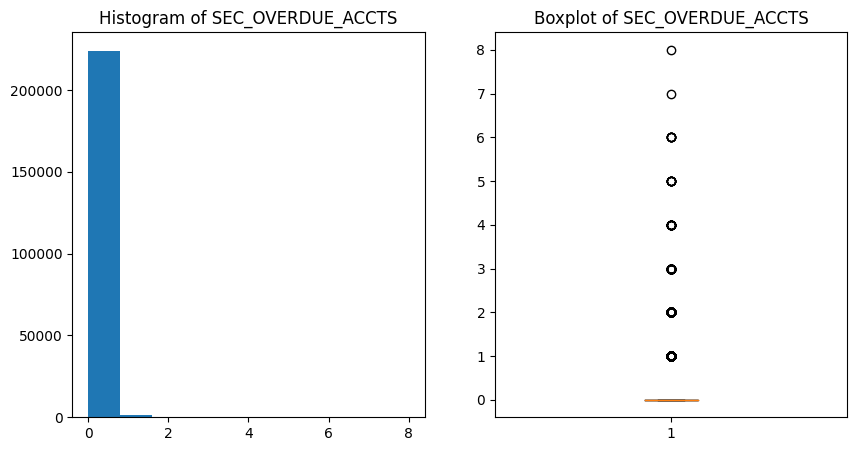

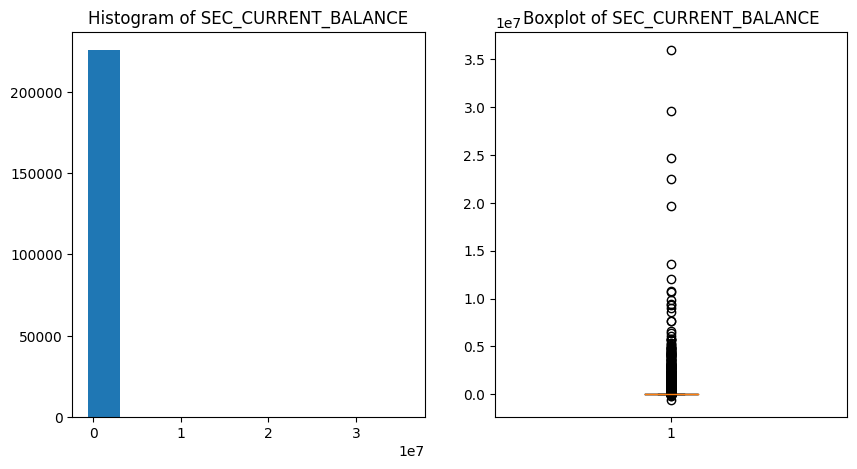

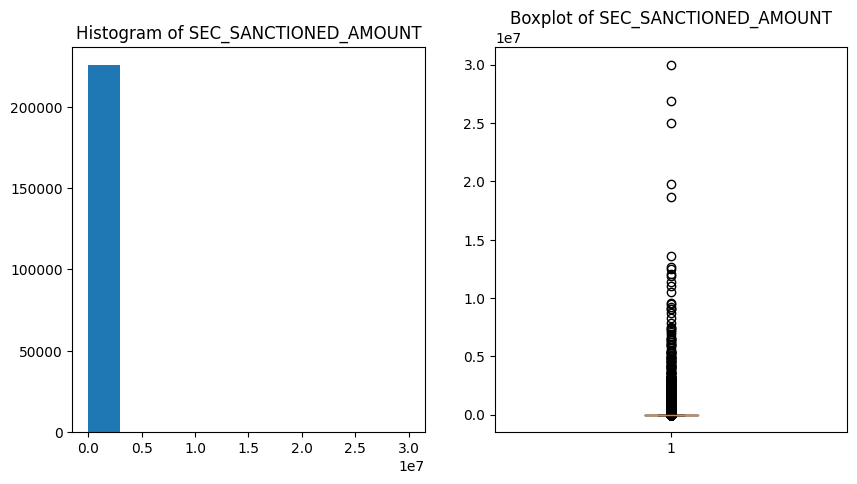

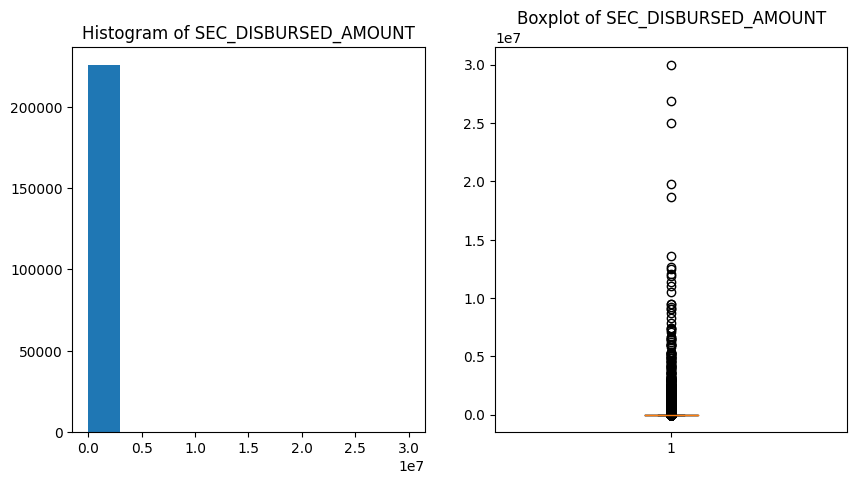

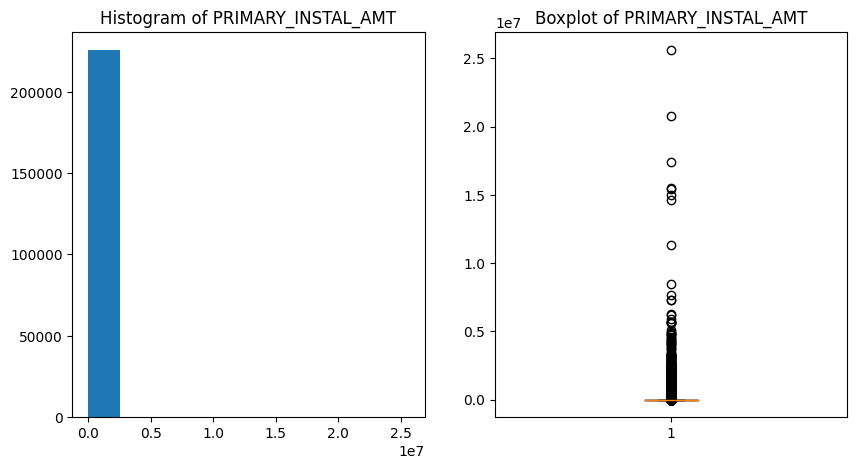

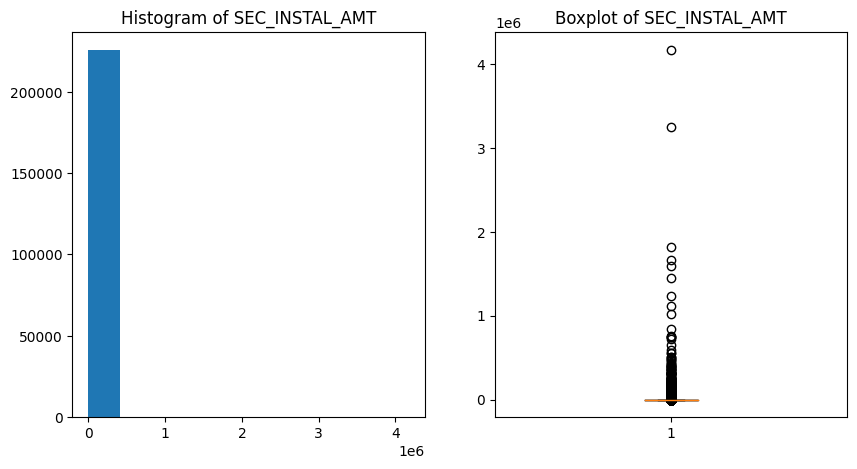

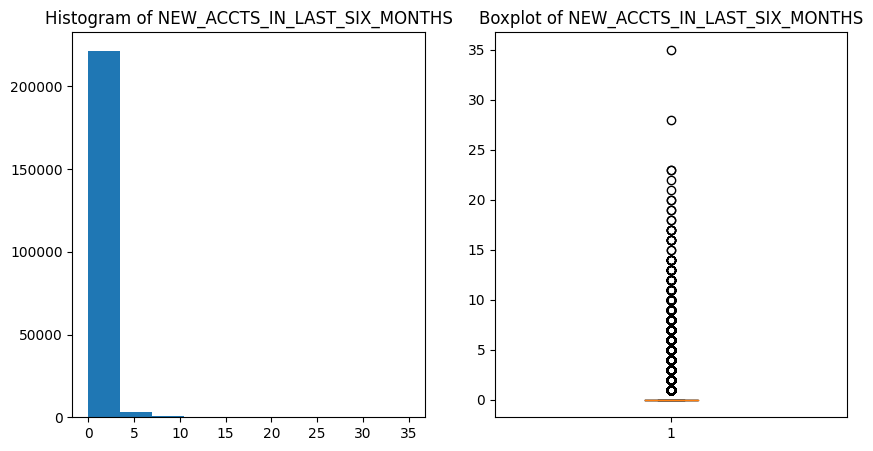

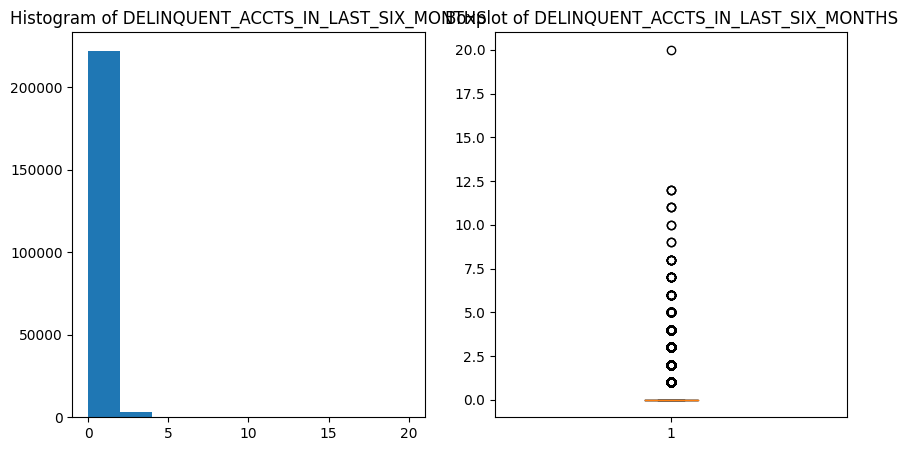

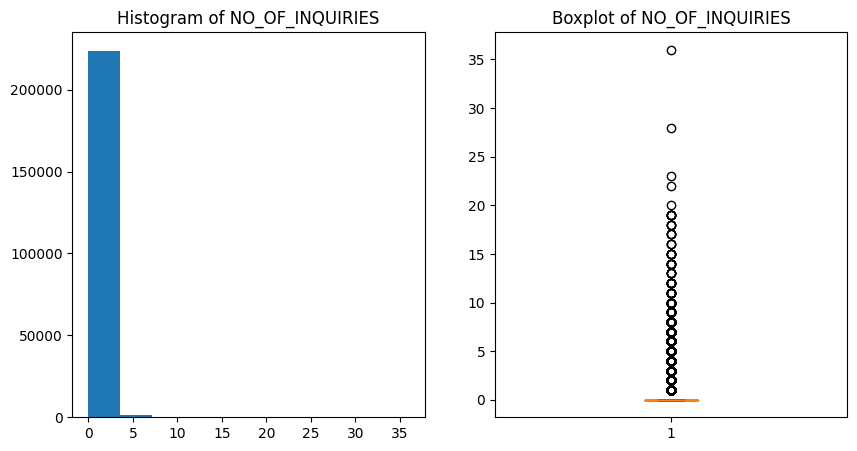

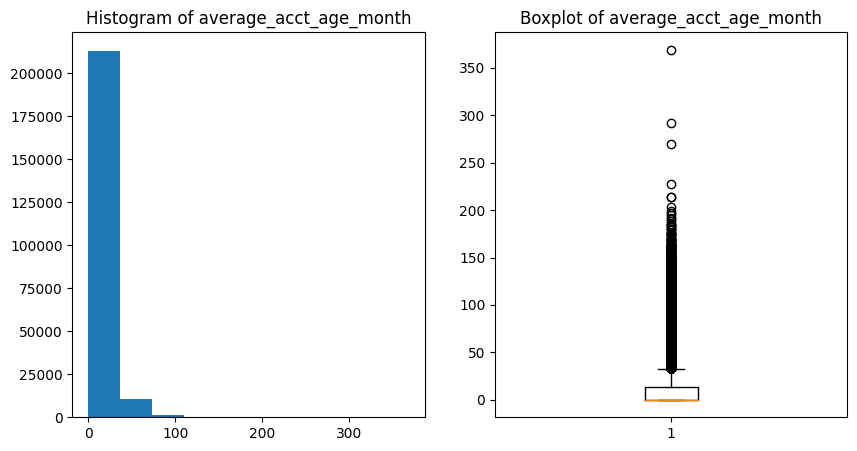

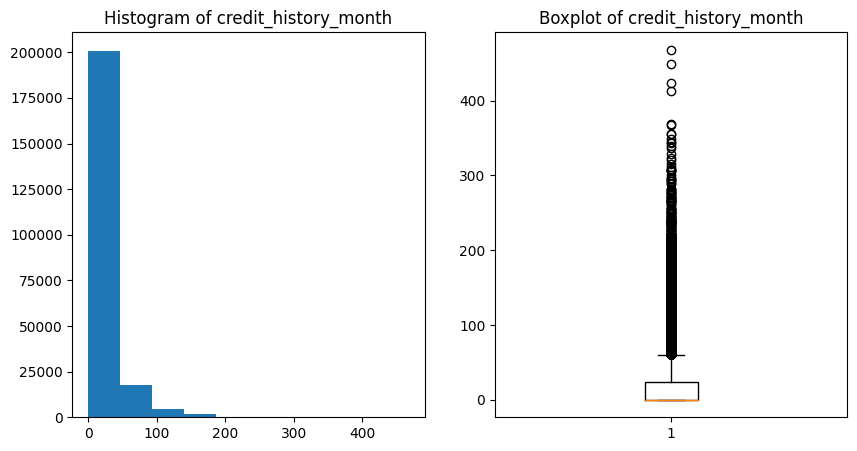

In [7]:
q_feature_list = ['ASSET_COST','LTV','AGE','PERFORM_CNS_SCORE','PRI_NO_OF_ACCTS','PRI_ACTIVE_ACCTS','PRI_OVERDUE_ACCTS',
                 'PRI_CURRENT_BALANCE','PRI_SANCTIONED_AMOUNT','PRI_DISBURSED_AMOUNT','SEC_NO_OF_ACCTS',
                 'SEC_ACTIVE_ACCTS','SEC_OVERDUE_ACCTS','SEC_CURRENT_BALANCE','SEC_SANCTIONED_AMOUNT',
                  'SEC_DISBURSED_AMOUNT','PRIMARY_INSTAL_AMT','SEC_INSTAL_AMT','NEW_ACCTS_IN_LAST_SIX_MONTHS',
                 'DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS','NO_OF_INQUIRIES','average_acct_age_month',
                  'credit_history_month']




# Loop through each feature name and create a histogram and boxplot side by side
for feature in q_feature_list:
    # Create a figure with two subplots
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Create the histogram on the left subplot
    axs[0].hist(df[feature], bins=10)
    axs[0].set_title(f'Histogram of {feature}')

    # Create the boxplot on the right subplot
    axs[1].boxplot(df[feature])
    axs[1].set_title(f'Boxplot of {feature}')

    # Save the figure as a PNG file
    plt.savefig(f'{feature}_hist_box.png')

    # Show the figure
    plt.show()


### Remove the Outliers
---
To get rid of the outliers we have used the interquartile range method.The interquartile range (IQR) method is used to remove outliers from a dataset. It involves calculating the IQR and identifying data points outside the defined outlier boundaries for removal.

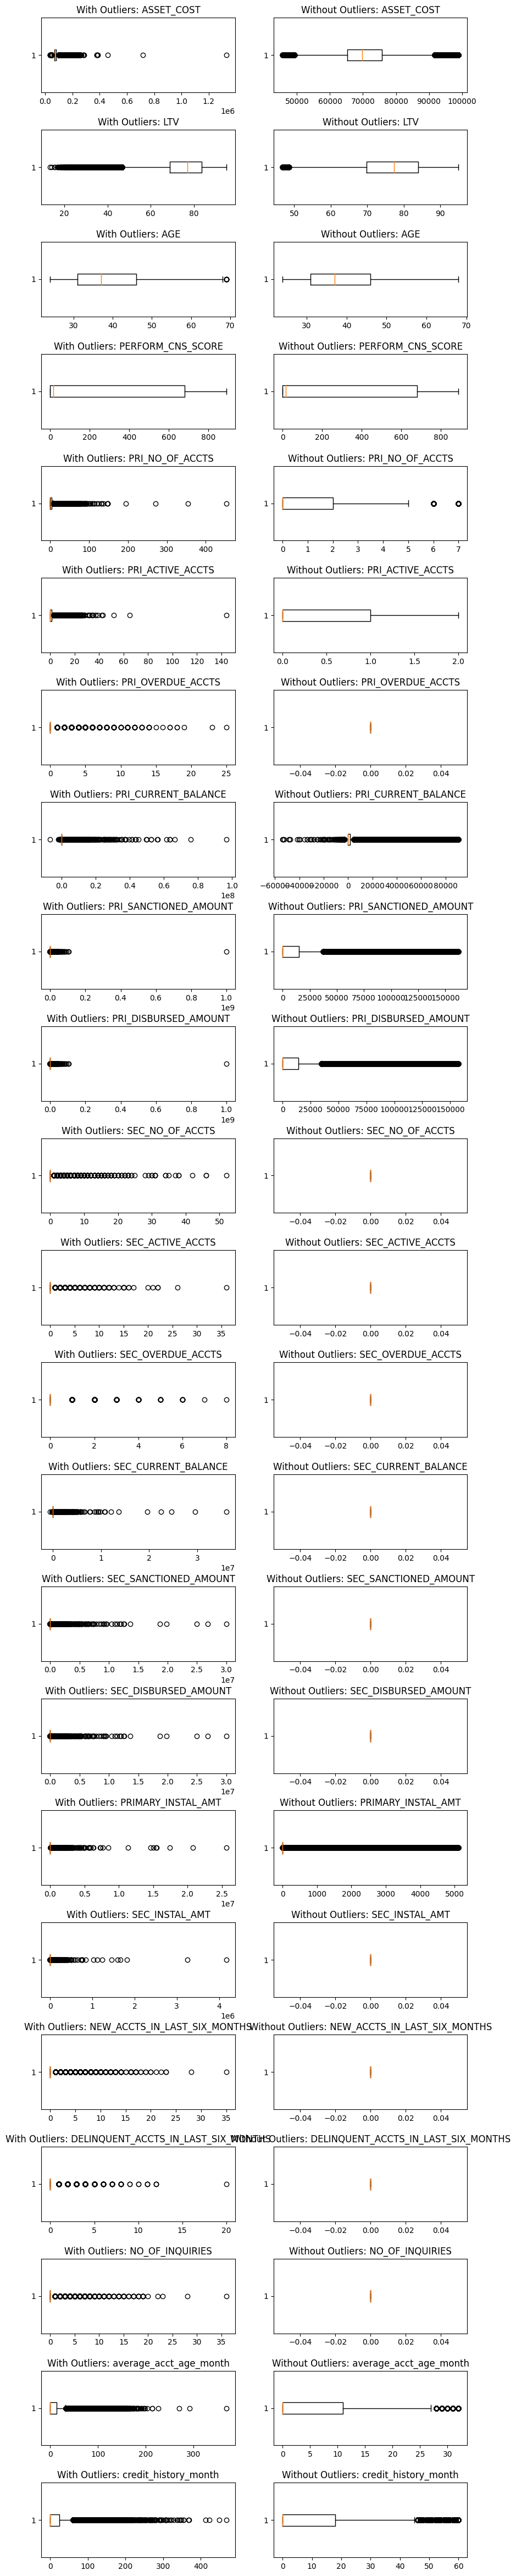

In [8]:
fig, axs = plt.subplots(nrows=len(q_feature_list), ncols=2, figsize=(10, 60))

# Loop over each quantitative feature in your list
for i, feature in enumerate(q_feature_list):
    
    # Create a box plot with outliers on the left subplot
    axs[i, 0].boxplot(df[feature], vert=False)
    axs[i, 0].set_title(f'With Outliers: {feature}')
    
    # Calculate the IQR for the feature
    q1 = df[feature].quantile(0.25)
    q3 = df[feature].quantile(0.75)
    iqr = q3 - q1
    
    # Remove outliers from the feature
    df_no_outliers = df[(df[feature] >= q1 - 1.5*iqr) & (df[feature] <= q3 + 1.5*iqr)]
    
    # Create a box plot without outliers on the right subplot
    axs[i, 1].boxplot(df_no_outliers[feature], vert=False)
    axs[i, 1].set_title(f'Without Outliers: {feature}')
    
# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.5)

# Display the plot
plt.show()


### Quantitative feature scaling
---
Since most of the machine learning methods use the distance between two datapoints if the quantitative features are in different scales some of the quantitaive features would dominate over the other quantitaive features purely based on the scale discrepancy which would lead to incorrect classification of the machine learning model so inorder to avoid that we need to scale the quantitaive features. But here some of the scaling methods assume that the features do not have any outliers and features are normally distributed. So here we are resorting to power tranformation method of yeo jhonson transformation which is more robus to work with features do not assume normal distribution.

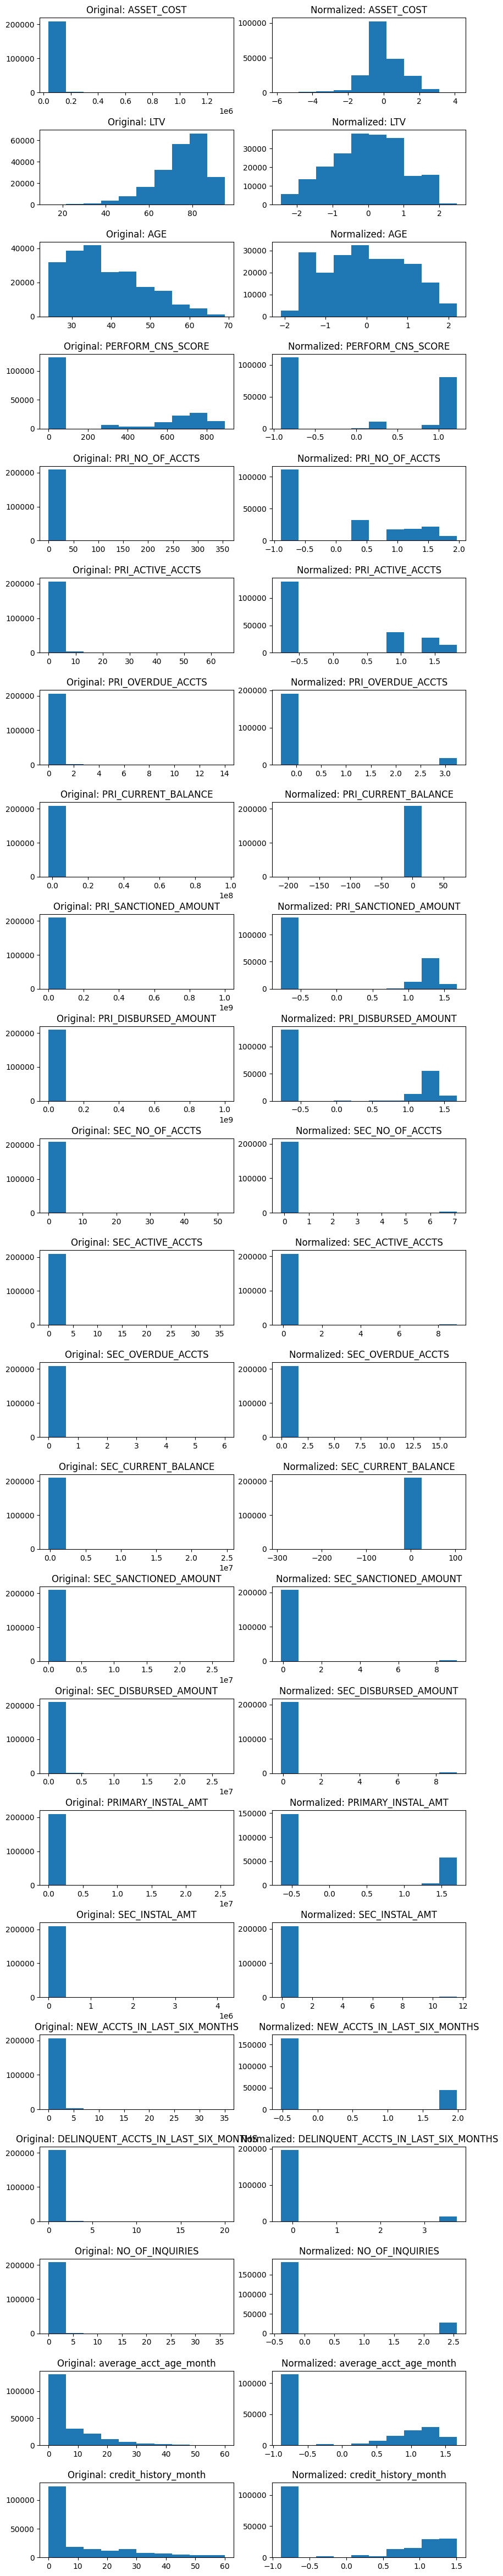

In [9]:
df = df_no_outliers
#print(df.shape)


# Create a copy of the original DataFrame to store normalized data
df_norm = df.copy()

# Create a MinMaxScaler object to normalize data
scaler = PowerTransformer(method='yeo-johnson')

# Loop over each quantitative feature in your list
for feature in q_feature_list:
    # Check if the feature is in the DataFrame
    if feature in df_norm.columns:
        # Apply the scaler to the feature and replace it in the DataFrame
        df_norm[feature] = scaler.fit_transform(df_norm[[feature]])

# Display the first few rows of the normalized DataFrame
fig, axs = plt.subplots(nrows=len(q_feature_list), ncols=2, figsize=(10, 60))

# Loop over each quantitative feature in your list
for i, feature in enumerate(q_feature_list):
    
    # Plot the histogram of the feature from the original dataframe on the left subplot
    axs[i, 0].hist(df[feature], bins=10)
    axs[i, 0].set_title(f'Original: {feature}')
    
    # Plot the histogram of the normalized feature on the right subplot
    axs[i, 1].hist(df_norm[feature], bins=10)
    axs[i, 1].set_title(f'Normalized: {feature}')
    
# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.5)

# Display the plot
plt.show()

In [10]:
df = df_norm
print(df_norm.shape)

(209774, 31)


Here we have used the yeo jhonson tranformation to improve the normality of the skewed features so two sample t test can be employed to meassure the statistical significance to rank each feature.

In [11]:
response_var = 'LOAN_DEFAULT'
# Define an empty dictionary to store the t-test results
t_test_results = {'feature': [], 't-value': [], 'p-value': []}

# Loop over each quantitative feature in your list
for feature in q_feature_list:
    
    # Perform the t-test
    group1 = df[df[response_var]==0][feature]
    group2 = df[df[response_var]==1][feature]
    t, p = ttest_ind(group1, group2, equal_var=False)
    
    # Store the results in the dictionary
    t_test_results['feature'].append(feature)
    t_test_results['t-value'].append(t)
    t_test_results['p-value'].append(p)

# Create a dataframe from the dictionary
results_df = pd.DataFrame(t_test_results)

# Sort the dataframe by ascending p-value
results_df = results_df.sort_values(by=['p-value'])

# Display the results
print(results_df)

                                feature    t-value        p-value
1                                   LTV -48.506674   0.000000e+00
6                     PRI_OVERDUE_ACCTS -24.046696  3.216546e-127
19  DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS -18.318896   8.949139e-75
20                      NO_OF_INQUIRIES -17.237968   1.895452e-66
4                       PRI_NO_OF_ACCTS  15.800636   3.782631e-56
3                     PERFORM_CNS_SCORE  15.257254   1.763547e-52
22                 credit_history_month  14.308972   2.212486e-46
18         NEW_ACCTS_IN_LAST_SIX_MONTHS  13.924443   5.082060e-44
2                                   AGE  13.881683   9.275977e-44
21               average_acct_age_month  13.496845   1.824945e-41
5                      PRI_ACTIVE_ACCTS  11.537004   9.106825e-31
8                 PRI_SANCTIONED_AMOUNT  10.808197   3.294949e-27
9                  PRI_DISBURSED_AMOUNT  10.455857   1.433761e-25
7                   PRI_CURRENT_BALANCE   9.511345   1.947533e-21
0         

## Statistical significance of binary features.
---
Here I have used the logistic regression to find the statistical significance between categorical features and categorical response variable. so here we get the coefficients and rank them based on the absoluite value of the cofficient

In [12]:
df['EMPLOYMENT_TYPE'] = df['EMPLOYMENT_TYPE'].replace({'Salaried': 1, 'Self employed': 0})

In [13]:
feature_names = ['MOBILENO_AVL_FLAG', 'AADHAR_FLAG', 'PAN_FLAG', 'VOTERID_FLAG', 'DRIVING_FLAG', 
                 'EMPLOYMENT_TYPE','PASSPORT_FLAG']

# Create an empty list to store the regression coefficients
coefficients = []

# Fit a logistic regression model for each feature variable
for feature in feature_names:
    X = df[[feature]]
    y = df['LOAN_DEFAULT']
    model = LogisticRegression().fit(X, y)
    coefficients.append(model.coef_[0][0])

# Create a DataFrame to store the feature names and coefficients
results_df = pd.DataFrame({'feature': feature_names, 'coefficient': coefficients})

# Sort the DataFrame in descending order by coefficient
results_df = results_df.sort_values('coefficient', ascending=False)

# Print the results
print(results_df)



             feature  coefficient
3       VOTERID_FLAG     0.284766
2           PAN_FLAG     0.015286
4       DRIVING_FLAG    -0.080942
5    EMPLOYMENT_TYPE    -0.127745
1        AADHAR_FLAG    -0.264144
6      PASSPORT_FLAG    -0.326129
0  MOBILENO_AVL_FLAG    -0.630166


Here we can remove the features 'PAN_FLAG' and 'DRIVING_FLAG' because of their statistical insignificance. due to the fact that the absolute value of their coefficient is being small. 

In [14]:
df = df.drop('PAN_FLAG', axis=1)
df = df.drop('DRIVING_FLAG', axis=1)

Based on the staitical significance of the each quantitaive feature against the response variable 'LOAN_DEFAULT' using the two sample t-test we have concluded to remove 'SEC_OVERDUE_ACCOUNT' due to its low statitical insignificance

In [15]:
df=df.drop('SEC_OVERDUE_ACCTS',axis=1)
df=df.drop('PRIMARY_INSTAL_AMT',axis=1)

---
**In this step we have filtered out the features that are statitically significant**
---
---


# Step Two - Feature Selection
---

Here we have used random forest feature selection method to select the best subset of features. 


In [16]:
df.head

<bound method NDFrame.head of         ASSET_COST       LTV       AGE  EMPLOYMENT_TYPE  MOBILENO_AVL_FLAG  \
0        -1.323369  1.630953  0.254795                1                  1   
1        -0.555822 -0.326791  0.035039                0                  1   
2        -0.980763  1.642816  0.035039                0                  1   
3        -0.503404  1.474572 -1.085918                0                  1   
4        -1.099031  1.461612  0.815139                0                  1   
...            ...       ...       ...              ...                ...   
233149    1.633344 -1.293186 -0.205281                1                  1   
233150    1.472687 -0.160663 -0.205281                0                  1   
233151   -0.071544 -1.892752  0.975193                1                  1   
233152    0.084557 -1.868218 -1.085918                1                  1   
233153    1.934586 -0.873250  0.254795                1                  1   

        AADHAR_FLAG  VOTERID_FLAG

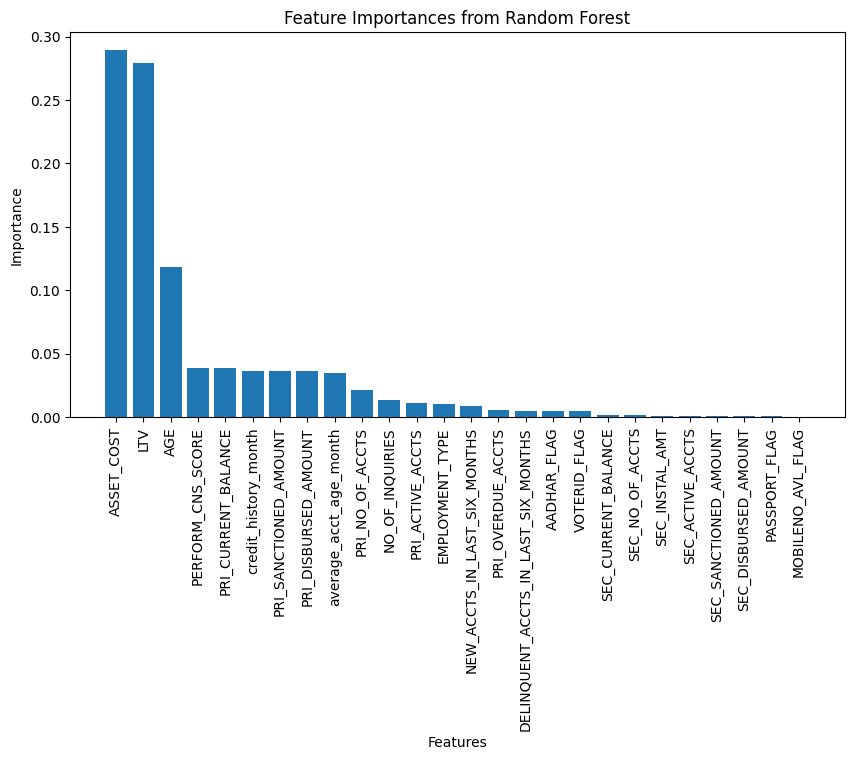

In [17]:
# Separate the response variable from the features
X = df.drop('LOAN_DEFAULT', axis=1)
y = df['LOAN_DEFAULT']

# Initialize the Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

rf.fit(X, y)

# Get the feature importances from the trained model
importances = rf.feature_importances_

# Sort the feature importances in descending order
indices = np.argsort(importances)[::-1]
sorted_features = X.columns[indices]
sorted_importances = importances[indices]

# Create a bar plot of the feature importances
plt.figure(figsize=(10, 5))
plt.bar(sorted_features, sorted_importances)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances from Random Forest')
plt.show()


In [18]:
# Use Random Forest feature selection to select the best subset of features
sfm = SelectFromModel(rf, threshold=0.03)
X_selected = sfm.fit_transform(X, y)

# Get the indices of the selected features
selected_indices = sfm.get_support(indices=True)

# Get the names of the selected features
selected_features = X.columns[selected_indices]

# Create a new data frame with the selected features and the response variable
df_rf_filtered = pd.concat([df[selected_features], y], axis=1)


In [19]:
df_rf_filtered.columns

Index(['ASSET_COST', 'LTV', 'AGE', 'PERFORM_CNS_SCORE', 'PRI_CURRENT_BALANCE',
       'PRI_SANCTIONED_AMOUNT', 'PRI_DISBURSED_AMOUNT',
       'average_acct_age_month', 'credit_history_month', 'LOAN_DEFAULT'],
      dtype='object')

## Selection a Model
---
### Model One - Linear Discriminant Analysis
---

In [20]:
loan_default_counts = df['LOAN_DEFAULT'].value_counts(normalize=True) * 100

print(loan_default_counts)

0    77.909083
1    22.090917
Name: LOAN_DEFAULT, dtype: float64


Here since one category of the reponse variable is under represented we have used Smote to balance the dataset but this practice has led to overall loss of cross validation score in each model we have used it nevertheless it has improved other performance indicators like AUPRC and AUROC

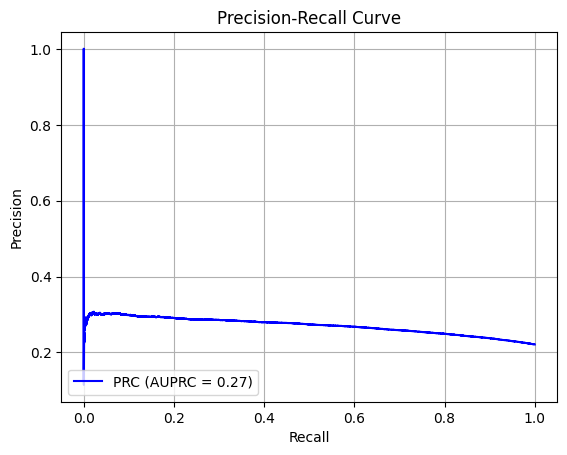

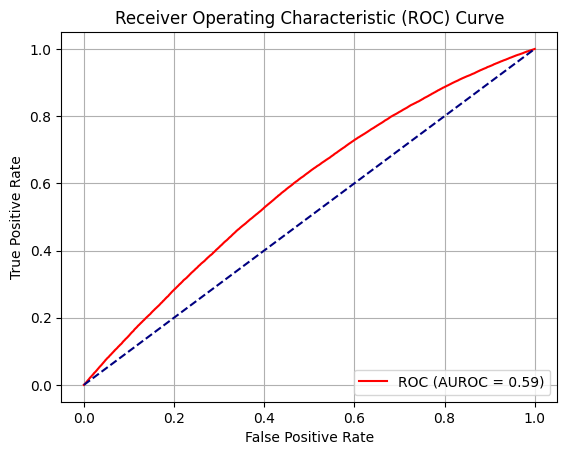

Mean score: 0.779076530050701
Standard deviation: 2.7146003917981513e-05


In [21]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt

lda_model = LinearDiscriminantAnalysis()

# Perform 5-fold cross-validation on the data and compute the scores
scores = cross_val_score(lda_model, df_rf_filtered.drop('LOAN_DEFAULT', axis=1), 
                         df_rf_filtered['LOAN_DEFAULT'], cv=5, n_jobs=-1)

# Get predicted probabilities for each fold
proba_scores = cross_val_predict(lda_model, df_rf_filtered.drop('LOAN_DEFAULT', axis=1), 
                                 df_rf_filtered['LOAN_DEFAULT'], cv=5, method='predict_proba')

# Compute precision, recall, and thresholds for PRC
precision, recall, thresholds_prc = precision_recall_curve(df_rf_filtered['LOAN_DEFAULT'], 
                                                           proba_scores[:, 1])

# Compute false positive rate, true positive rate, and thresholds for ROC
fpr, tpr, thresholds_roc = roc_curve(df_rf_filtered['LOAN_DEFAULT'], proba_scores[:, 1])

# Compute AUPRC and AUROC
auprc = auc(recall, precision)
auroc = auc(fpr, tpr)

# Plot Precision-Recall Curve
plt.figure()
plt.plot(recall, precision, color='b', label='PRC (AUPRC = %0.2f)' % auprc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='r', label='ROC (AUROC = %0.2f)' % auroc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Print the mean and standard deviation of the scores
print("Mean score:", np.mean(scores))
print("Standard deviation:", np.std(scores))

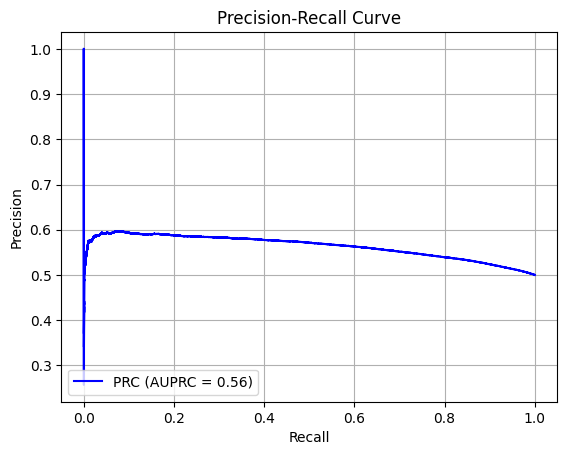

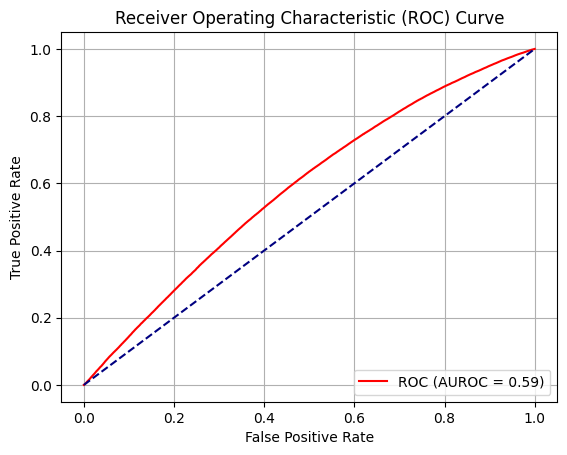

Mean score: 0.566935646398246
Standard deviation: 0.0065972214581350155


In [22]:
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt

lda_model = LinearDiscriminantAnalysis()

# Apply SMOTE to balance the response variable
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(df_rf_filtered.drop('LOAN_DEFAULT', axis=1),
                                              df_rf_filtered['LOAN_DEFAULT'])

# Perform 5-fold cross-validation on the resampled data and compute the scores
scores = cross_val_score(lda_model, X_resampled, y_resampled, cv=5, n_jobs=-1)

# Get predicted probabilities for each fold
proba_scores = cross_val_predict(lda_model, X_resampled, y_resampled, cv=5, method='predict_proba')

# Compute precision, recall, and thresholds for PRC
precision, recall, thresholds_prc = precision_recall_curve(y_resampled, proba_scores[:, 1])

# Compute false positive rate, true positive rate, and thresholds for ROC
fpr, tpr, thresholds_roc = roc_curve(y_resampled, proba_scores[:, 1])

# Compute AUPRC and AUROC
auprc = auc(recall, precision)
auroc = auc(fpr, tpr)

# Plot Precision-Recall Curve
plt.figure()
plt.plot(recall, precision, color='b', label='PRC (AUPRC = %0.2f)' % auprc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='r', label='ROC (AUROC = %0.2f)' % auroc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Print the mean and standard deviation of the scores
print("Mean score:", np.mean(scores))
print("Standard deviation:", np.std(scores))



## Model 2 Random Forest
---


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


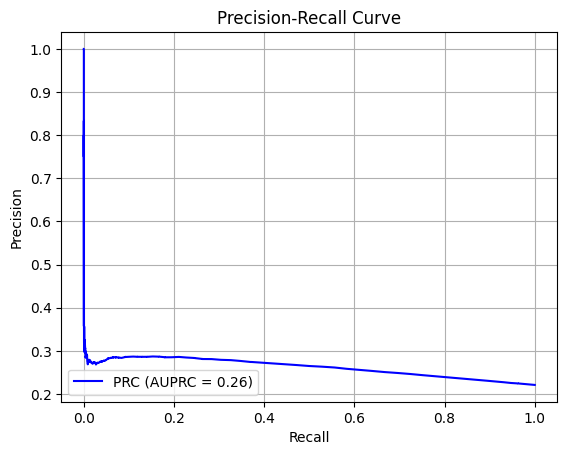

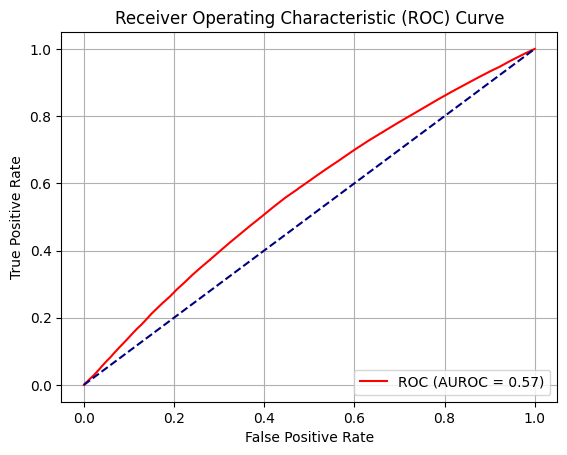

Mean score: 0.757095729188662
Standard deviation: 0.0018377518792952762


In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.model_selection import cross_val_score, cross_val_predict
import matplotlib.pyplot as plt

# Create the random forest classifier object
rf_model = RandomForestClassifier()

# Perform 5-fold cross-validation on the data and compute the scores
scores = cross_val_score(rf_model, df_rf_filtered.drop('LOAN_DEFAULT', axis=1), 
                         df_rf_filtered['LOAN_DEFAULT'], cv=5, n_jobs=-1)

# Get predicted probabilities for each fold
proba_scores = cross_val_predict(rf_model, df_rf_filtered.drop('LOAN_DEFAULT', axis=1), 
                                 df_rf_filtered['LOAN_DEFAULT'], cv=5, method='predict_proba')

# Compute precision, recall, and thresholds for PRC
precision, recall, thresholds_prc = precision_recall_curve(df_rf_filtered['LOAN_DEFAULT'], 
                                                           proba_scores[:, 1])

# Compute false positive rate, true positive rate, and thresholds for ROC
fpr, tpr, thresholds_roc = roc_curve(df_rf_filtered['LOAN_DEFAULT'], proba_scores[:, 1])

# Compute AUPRC and AUROC
auprc = auc(recall, precision)
auroc = auc(fpr, tpr)

# Plot Precision-Recall Curve
plt.figure()
plt.plot(recall, precision, color='b', label='PRC (AUPRC = %0.2f)' % auprc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='r', label='ROC (AUROC = %0.2f)' % auroc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Print the mean and standard deviation of the scores
print("Mean score:", np.mean(scores))
print("Standard deviation:", np.std(scores))



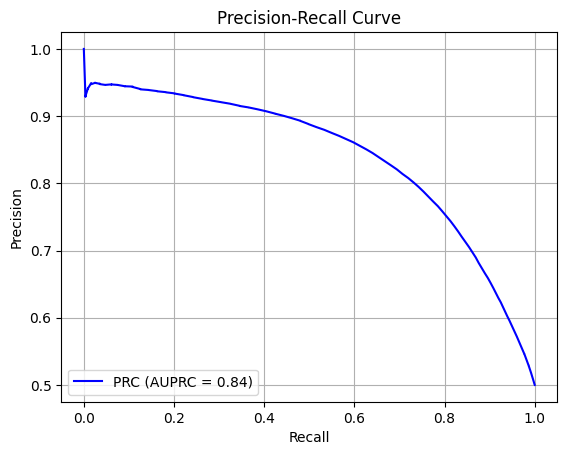

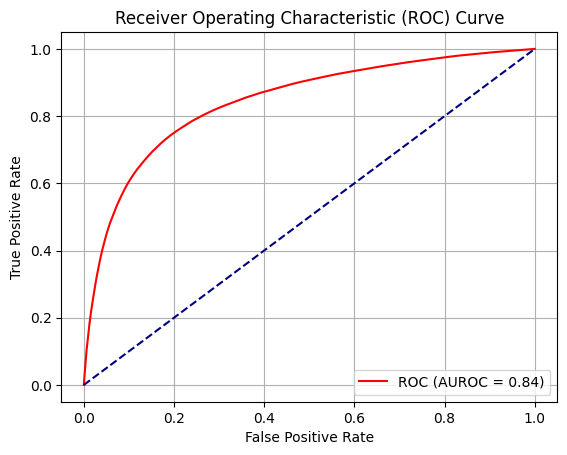

Mean score: 0.7736690355505434
Standard deviation: 0.05602333745047606


In [24]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.model_selection import cross_val_score, cross_val_predict
import matplotlib.pyplot as plt

# Apply SMOTE to balance the data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(df_rf_filtered.drop('LOAN_DEFAULT', axis=1),
                                              df_rf_filtered['LOAN_DEFAULT'])

# Create the random forest classifier object
rf_model = RandomForestClassifier()

# Perform 5-fold cross-validation on the resampled data and compute the scores
scores = cross_val_score(rf_model, X_resampled, y_resampled, cv=5, n_jobs=-1)

# Get predicted probabilities for each fold
proba_scores = cross_val_predict(rf_model, X_resampled, y_resampled, cv=5, method='predict_proba')

# Compute precision, recall, and thresholds for PRC
precision, recall, thresholds_prc = precision_recall_curve(y_resampled, proba_scores[:, 1])

# Compute false positive rate, true positive rate, and thresholds for ROC
fpr, tpr, thresholds_roc = roc_curve(y_resampled, proba_scores[:, 1])

# Compute AUPRC and AUROC
auprc = auc(recall, precision)
auroc = auc(fpr, tpr)

# Plot Precision-Recall Curve
plt.figure()
plt.plot(recall, precision, color='b', label='PRC (AUPRC = %0.2f)' % auprc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='r', label='ROC (AUROC = %0.2f)' % auroc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Print the mean and standard deviation of the scores
print("Mean score:", np.mean(scores))
print("Standard deviation:", np.std(scores))


## Naive Bayes Method

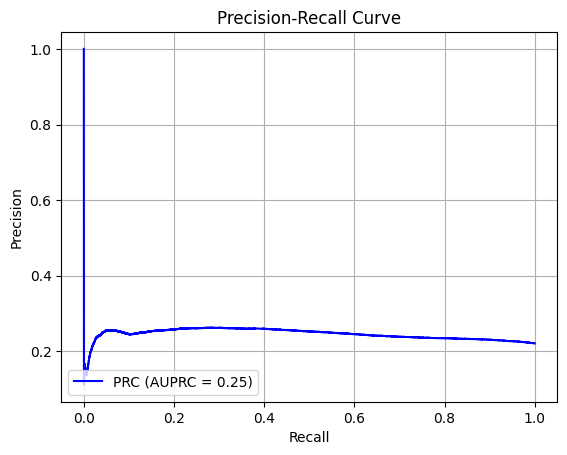

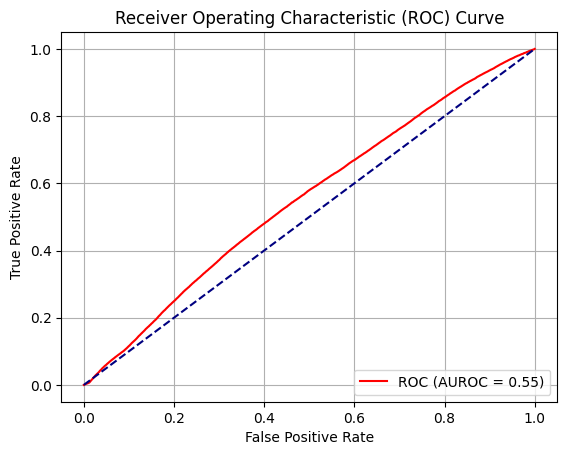

Mean score: 0.7723216316157926
Standard deviation: 0.003547442954033123


In [25]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.model_selection import cross_val_score, cross_val_predict
import matplotlib.pyplot as plt

# Create the Naive Bayes classifier object
nb_model = GaussianNB()

# Perform 5-fold cross-validation on the data and compute the scores
scores = cross_val_score(nb_model, df_rf_filtered.drop('LOAN_DEFAULT', axis=1),
                         df_rf_filtered['LOAN_DEFAULT'], cv=5, n_jobs=-1)

# Get predicted probabilities for each fold
proba_scores = cross_val_predict(nb_model, df_rf_filtered.drop('LOAN_DEFAULT', axis=1),
                                 df_rf_filtered['LOAN_DEFAULT'], cv=5, method='predict_proba')

# Compute precision, recall, and thresholds for PRC
precision, recall, thresholds_prc = precision_recall_curve(df_rf_filtered['LOAN_DEFAULT'],
                                                           proba_scores[:, 1])

# Compute false positive rate, true positive rate, and thresholds for ROC
fpr, tpr, thresholds_roc = roc_curve(df_rf_filtered['LOAN_DEFAULT'], proba_scores[:, 1])

# Compute AUPRC and AUROC
auprc = auc(recall, precision)
auroc = auc(fpr, tpr)

# Plot Precision-Recall Curve
plt.figure()
plt.plot(recall, precision, color='b', label='PRC (AUPRC = %0.2f)' % auprc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='r', label='ROC (AUROC = %0.2f)' % auroc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Print the mean and standard deviation of the scores
print("Mean score:", np.mean(scores))
print("Standard deviation:", np.std(scores))


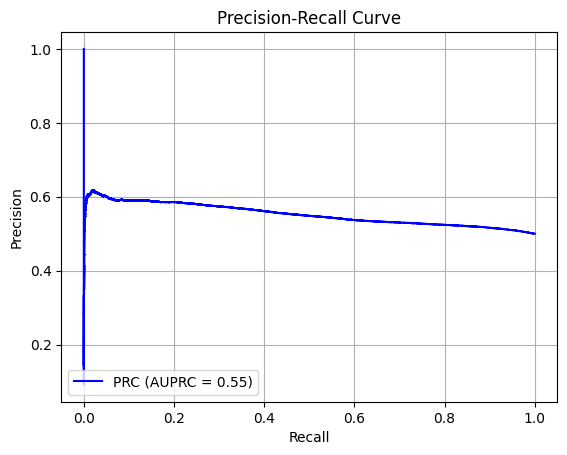

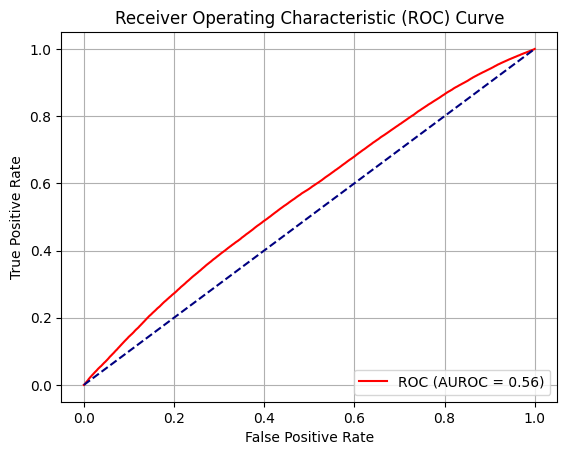

Mean score: 0.5417021183232905
Standard deviation: 0.003782732241177862


In [26]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.model_selection import cross_val_score, cross_val_predict
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Create the Naive Bayes classifier object
nb_model = GaussianNB()

# Perform SMOTE to balance the data
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(df_rf_filtered.drop('LOAN_DEFAULT', axis=1),
                                              df_rf_filtered['LOAN_DEFAULT'])

# Perform 5-fold cross-validation on the resampled data and compute the scores
scores = cross_val_score(nb_model, X_resampled, y_resampled, cv=5, n_jobs=-1)

# Get predicted probabilities for each fold
proba_scores = cross_val_predict(nb_model, X_resampled, y_resampled, cv=5, method='predict_proba')

# Compute precision, recall, and thresholds for PRC
precision, recall, thresholds_prc = precision_recall_curve(y_resampled, proba_scores[:, 1])

# Compute false positive rate, true positive rate, and thresholds for ROC
fpr, tpr, thresholds_roc = roc_curve(y_resampled, proba_scores[:, 1])

# Compute AUPRC and AUROC
auprc = auc(recall, precision)
auroc = auc(fpr, tpr)

# Plot Precision-Recall Curve
plt.figure()
plt.plot(recall, precision, color='b', label='PRC (AUPRC = %0.2f)' % auprc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='r', label='ROC (AUROC = %0.2f)' % auroc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Print the mean and standard deviation of the scores
print("Mean score:", np.mean(scores))
print("Standard deviation:", np.std(scores))


## XG-BOOST

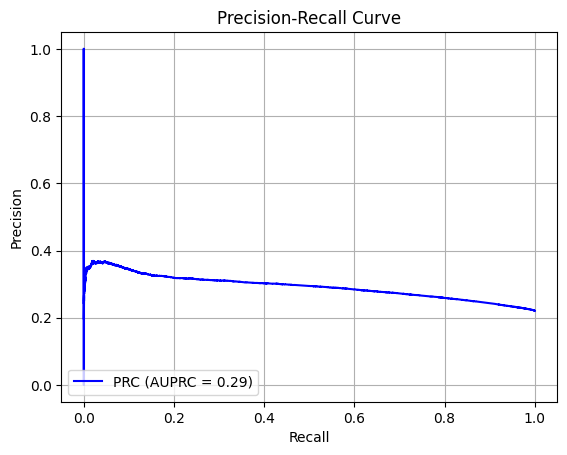

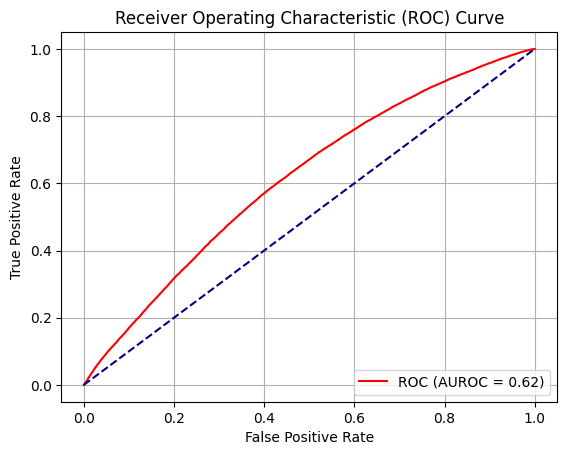

Mean score: 0.7778132649803268
Standard deviation: 0.00026746221784937113


In [27]:
import xgboost as xgb
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.model_selection import cross_val_score, cross_val_predict
import matplotlib.pyplot as plt

# Create XGBoost classifier object
xgb_model = xgb.XGBClassifier()

# Perform 5-fold cross-validation on the data and compute the scores
scores = cross_val_score(xgb_model, df_rf_filtered.drop('LOAN_DEFAULT', axis=1), 
                         df_rf_filtered['LOAN_DEFAULT'], cv=5, n_jobs=-1)

# Get predicted probabilities for each fold
proba_scores = cross_val_predict(xgb_model, df_rf_filtered.drop('LOAN_DEFAULT', axis=1), 
                                 df_rf_filtered['LOAN_DEFAULT'], cv=5, method='predict_proba')

# Compute precision, recall, and thresholds for PRC
precision, recall, thresholds_prc = precision_recall_curve(df_rf_filtered['LOAN_DEFAULT'], 
                                                           proba_scores[:, 1])

# Compute false positive rate, true positive rate, and thresholds for ROC
fpr, tpr, thresholds_roc = roc_curve(df_rf_filtered['LOAN_DEFAULT'], proba_scores[:, 1])

# Compute AUPRC and AUROC
auprc = auc(recall, precision)
auroc = auc(fpr, tpr)

# Plot Precision-Recall Curve
plt.figure()
plt.plot(recall, precision, color='b', label='PRC (AUPRC = %0.2f)' % auprc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='r', label='ROC (AUROC = %0.2f)' % auroc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Print the mean and standard deviation of the scores
print("Mean score:", np.mean(scores))
print("Standard deviation:", np.std(scores))


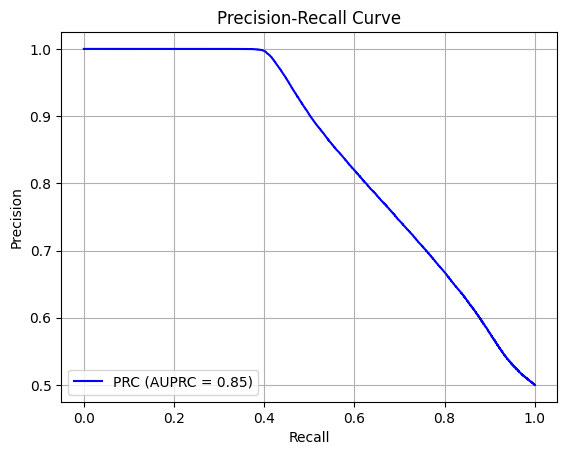

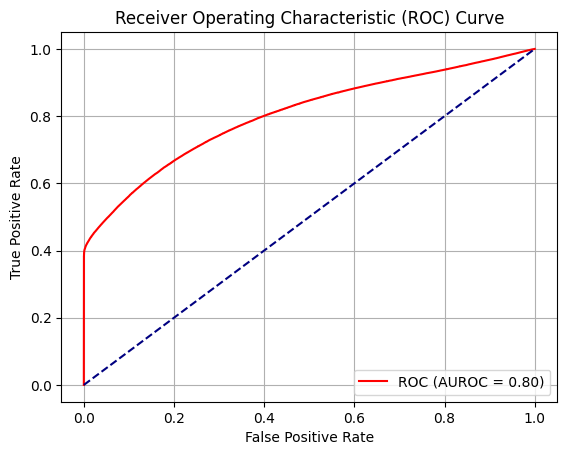

Mean score: 0.7312941324040386
Standard deviation: 0.10149789199510403


In [28]:
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.model_selection import cross_val_score, cross_val_predict
import matplotlib.pyplot as plt

# Create SMOTE object
smote = SMOTE()

# Apply SMOTE to balance the dataset
X_resampled, y_resampled = smote.fit_resample(df_rf_filtered.drop('LOAN_DEFAULT', axis=1), 
                                              df_rf_filtered['LOAN_DEFAULT'])

# Create XGBoost classifier object
xgb_model = xgb.XGBClassifier()

# Perform 5-fold cross-validation on the resampled data and compute the scores
scores = cross_val_score(xgb_model, X_resampled, y_resampled, cv=5, n_jobs=-1)

# Get predicted probabilities for each fold
proba_scores = cross_val_predict(xgb_model, X_resampled, y_resampled, cv=5, method='predict_proba')

# Compute precision, recall, and thresholds for PRC
precision, recall, thresholds_prc = precision_recall_curve(y_resampled, proba_scores[:, 1])

# Compute false positive rate, true positive rate, and thresholds for ROC
fpr, tpr, thresholds_roc = roc_curve(y_resampled, proba_scores[:, 1])

# Compute AUPRC and AUROC
auprc = auc(recall, precision)
auroc = auc(fpr, tpr)

# Plot Precision-Recall Curve
plt.figure()
plt.plot(recall, precision, color='b', label='PRC (AUPRC = %0.2f)' % auprc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='r', label='ROC (AUROC = %0.2f)' % auroc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Print the mean and standard deviation of the scores
print("Mean score:", np.mean(scores))
print("Standard deviation:", np.std(scores))


## Hyperparameter Tuning 
---
Here we have used randomsearch cv instead of gridsearch cv inorder to avoid the high computation usage. Nevertheless anyone who have access to a high computaion power can run the following code instead of the random search cv and obtain more accurate results.
```python
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV
import matplotlib.pyplot as plt

# Apply SMOTE to balance the data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(df_rf_filtered.drop('LOAN_DEFAULT', axis=1),
                                              df_rf_filtered['LOAN_DEFAULT'])

# Create the random forest classifier object
rf_model = RandomForestClassifier()

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the grid search to the resampled data
grid_search.fit(X_resampled, y_resampled)

# Get the best estimator and its performance
best_model = grid_search.best_estimator_
best_score = grid_search.best_score_

# Perform cross-validation on the best model
scores = cross_val_score(best_model, X_resampled, y_resampled, cv=5, n_jobs=-1)

# Get predicted probabilities for each fold
proba_scores = cross_val_predict(best_model, X_resampled, y_resampled, cv=5, method='predict_proba')

# Compute precision, recall, and thresholds for PRC
precision, recall, thresholds_prc = precision_recall_curve(y_resampled, proba_scores[:, 1])

# Compute false positive rate, true positive rate, and thresholds for ROC
fpr, tpr, thresholds_roc = roc_curve(y_resampled, proba_scores[:, 1])

# Compute AUPRC and AUROC
auprc = auc(recall, precision)
auroc = auc(fpr, tpr)

# Plot Precision-Recall Curve
plt.figure()
plt.plot(recall, precision, color='b', label='PRC (AUPRC = %0.2f)' % auprc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='r', label='ROC (AUROC = %0.2f)' % auroc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Print the best score from the grid search
print("Best Score:", best_score)

# Print the mean and standard deviation of the scores
print("Mean score:", np.mean(scores))
print("Standard deviation:", np.std(scores))

# Print the best parameters
print("Best Parameters:", grid_search.best_params_)


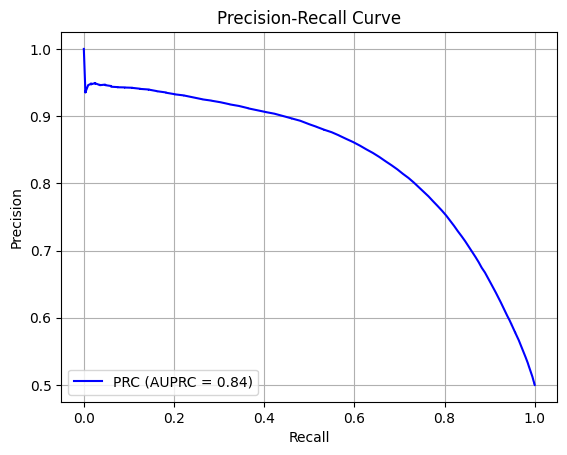

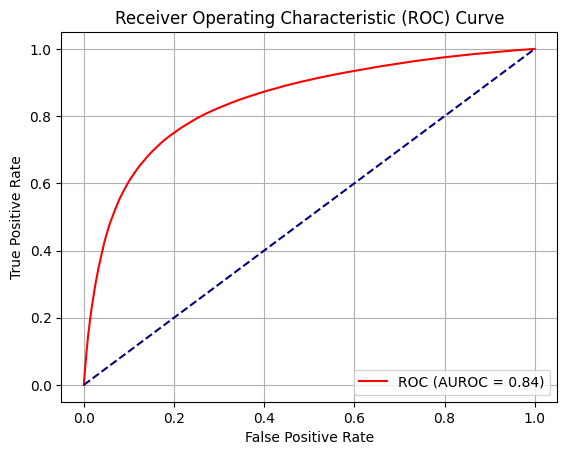

Best Score: 0.7737546958615059
Mean score: 0.7743726818216076
Standard deviation: 0.0554047953381603
Best Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}


In [29]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.model_selection import cross_val_score, cross_val_predict, RandomizedSearchCV
import matplotlib.pyplot as plt

# Apply SMOTE to balance the data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(df_rf_filtered.drop('LOAN_DEFAULT', axis=1),
                                              df_rf_filtered['LOAN_DEFAULT'])

# Create the random forest classifier object
rf_model = RandomForestClassifier()

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(rf_model, param_distributions=param_grid, n_iter=10, cv=5,
                                   scoring='accuracy', random_state=42, n_jobs=-1)

# Fit the random search to the resampled data
random_search.fit(X_resampled, y_resampled)

# Get the best estimator and its performance
best_model = random_search.best_estimator_
best_score = random_search.best_score_

# Perform cross-validation on the best model
scores = cross_val_score(best_model, X_resampled, y_resampled, cv=5, n_jobs=-1)

# Get predicted probabilities for each fold
proba_scores = cross_val_predict(best_model, X_resampled, y_resampled, cv=5, method='predict_proba')

# Compute precision, recall, and thresholds for PRC
precision, recall, thresholds_prc = precision_recall_curve(y_resampled, proba_scores[:, 1])

# Compute false positive rate, true positive rate, and thresholds for ROC
fpr, tpr, thresholds_roc = roc_curve(y_resampled, proba_scores[:, 1])

# Compute AUPRC and AUROC
auprc = auc(recall, precision)
auroc = auc(fpr, tpr)

# Plot Precision-Recall Curve
plt.figure()
plt.plot(recall, precision, color='b', label='PRC (AUPRC = %0.2f)' % auprc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='r', label='ROC (AUROC = %0.2f)' % auroc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Print the best score from the random search
print("Best Score:", best_score)

# Print the mean and standard deviation of the scores
print("Mean score:", np.mean(scores))
print("Standard deviation:", np.std(scores))

# Print the best parameters
print("Best Parameters:", random_search.best_params_)



# Conclusion
---
Here we can conclude that the best performance is recorded when we use random forest classifier with SMOTE specially when we balance the data AUROC and AUPRC has increased significantly. Nevertheless hyperparameter tuning hasn't yield much results using random search cross validation. 